# URL Query Binary Classifier [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/christopherwoodall/ml-for-cybersecurity/blob/main/query-binary-classifier/query-binary-classifier.ipynb)
## Machine Learning for Cybersecurity


In this notebook we will go over creating a very simple URL classifier. In order to classify a URL as `BENIGN` or `MALICIOUS` we will be using LR(Logistic Regression), it requires a single input feature and returns `0` or `1`.

In [ ]:
%%bash
# Execute this cell if you are running this notebook in a remote
# jupyter environment. This process may take some time.
DATASET_DIR="./datasets"

if [ ! -d "${DATASET_DIR}" ]; then
  mkdir -p "${DATASET_DIR}"
  wget "https://github.com/christopherwoodall/ml-for-cybersecurity/blob/main/query-binary-classifier/datasets/benign_urls.json?raw=true" -O "${DATASET_DIR}/benign_urls.json"
  wget "https://github.com/christopherwoodall/ml-for-cybersecurity/blob/main/query-binary-classifier/datasets/malicious_urls.json?raw=true" -O "${DATASET_DIR}/malicious_urls.json"
  pip install sklearn matplotlib seaborn
fi

## Loading the Data

In [209]:
import json
import urllib.parse

from pathlib import Path


project_path   = Path.cwd()
datasets_path  = Path(project_path / "datasets")
benign_path    = Path(datasets_path / "benign_urls.json")
malicious_path = Path(datasets_path / "malicious_urls.json")

benign_data    = json.loads(benign_path.read_text(encoding="utf8"))
malicious_data = json.loads(malicious_path.read_text(encoding="utf8"))
all_data       = benign_data + malicious_data


# Splitting Data

Now we are going to split the data using `sklearn`'s `train_test_split()` function.


In [222]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split


vectorizer = TfidfVectorizer(min_df=0.0, analyzer="char", sublinear_tf=True, ngram_range=(1,3))

x           = vectorizer.fit_transform(all_data)
y_malicious = [0 for i in range(0,len(benign_data))]
y_benign    = [1 for i in range(0,len(malicious_data))]
y           = y_malicious + y_benign

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=16)


# Classifier

Next let's create a Logistic Regression (aka logit, MaxEnt) classifier; check out the docs [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

In [224]:
from sklearn.linear_model import LogisticRegression


classifier = LogisticRegression(
  class_weight = {1: 2 * len(benign_data) / len(malicious_data), 0: 1.0},
  max_iter     = 1000
).fit(x_train, y_train)


## Predictions

Now for the fun part. Below are a list of URLs and their categorization(benign or malicious).

In [231]:
import random


test_data = [
  "facebook.com/post",                                # BENIGN
  "example/test.php",                                 # BENIGN
  "?google/images",                                   # BENIGN
  "contact.php=foo/bar",                              # BENIGN
  "comment.php=foooooooooooooooobarbaaz",             # BENIGN
  "contact.php=\"';/><script>alert(1)</script>",      # MALICIOUS
  "login.php=SELECT password from admin",             # MALICIOUS
  "\"><svg onload=confirm(1)>",                       # MALICIOUS
  "q=../etc/passwd",                                  # MALICIOUS
  "contact/javascript:confirm(1)",                    # MALICIOUS
  "email.aspx=\"><svg onclick=alert(1)",              # MALICIOUS
  "<img src=xx onerror=confirm(1)>",                  # MALICIOUS
  "example/test/q=<script>alert(1)</script>",         # MALICIOUS
  "example/test/q=<svg onload=confirm('faizan')>",    # MALICIOUS
  "fsecurify/q=<svg onerror=confirm('fsecurify')>",   # MALICIOUS
  "example/test/q=<a href=\"javascript:confirm(1)>",  # MALICIOUS
]
random.shuffle(test_data)

for url in test_data:
  prediction = 'BENIGN' if not classifier.predict(vectorizer.transform([url])) else 'MALICIOUS'
  print(f"{prediction} | {url}")


MALICIOUS | q=../etc/passwd
MALICIOUS | <img src=xx onerror=confirm(1)>
MALICIOUS | example/test/q=<svg onload=confirm('faizan')>
MALICIOUS | fsecurify/q=<svg onerror=confirm('fsecurify')>
MALICIOUS | contact.php="';/><script>alert(1)</script>
MALICIOUS | login.php=SELECT password from admin
BENIGN | contact.php=foo/bar
MALICIOUS | contact/javascript:confirm(1)
BENIGN | comment.php=foooooooooooooooobarbaaz
MALICIOUS | email.aspx="><svg onclick=alert(1)
BENIGN | ?google/images
BENIGN | facebook.com/post
MALICIOUS | example/test/q=<script>alert(1)</script>
MALICIOUS | example/test/q=<a href="javascript:confirm(1)>
BENIGN | example/test.php
MALICIOUS | "><svg onload=confirm(1)>


## Confusion Matrix

This is a table used to visualize model *correctness*.

              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00    316515
   MALICIOUS       0.99      1.00      0.99     11164

    accuracy                           1.00    327679
   macro avg       0.99      1.00      1.00    327679
weighted avg       1.00      1.00      1.00    327679



Text(0.5, 427.9555555555555, 'Predicted label')

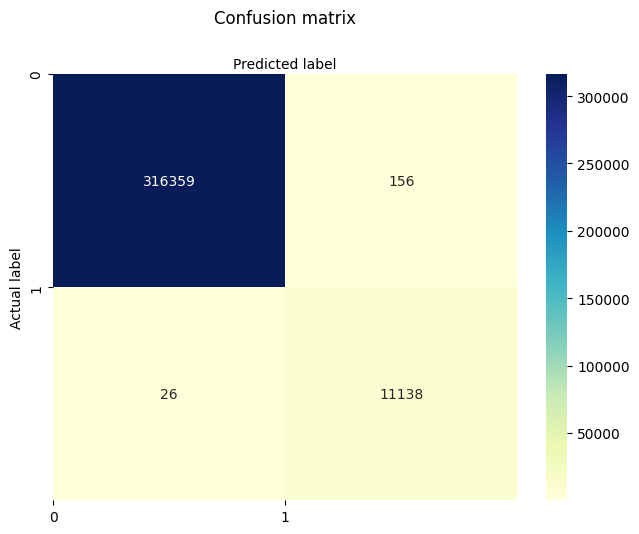

In [247]:
# import required modules
import numpy
import pandas
import seaborn

import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from sklearn import metrics


class_names = [0, 1]
target_names = ['BENIGN', 'MALICIOUS']

print(classification_report(y_test, y_pred, target_names=target_names))

y_pred = classifier.predict(x_test)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
tick_marks = numpy.arange(len(class_names))

fig, ax = plt.subplots()
seaborn.heatmap(pandas.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')



## Datasets

- [HTTP DATASET CSIC 2010](https://www.isi.csic.es/dataset/)[src](https://www.kaggle.com/datasets/ispangler/csic-2010-web-application-attacks) - Developed at the Information Security Institute of CSIC(Spanish Research National Council), the dataset ccontains thousands of automatically generated web request.
- [MACCDC2012](http://www.secrepo.com/) - Dataset containing everything from scanning/recon through explotation as well as some c99 shell traffic. Roughly 22694356 total connections.
- [fuzzdb](https://github.com/fuzzdb-project/fuzzdb) - The first and most comprehensive open dictionary of fault injection patterns, predictable resource locations, and regex for matching server responses.


## Resources
- [Binary Classification with Logistic Regression](https://python.plainenglish.io/binary-classification-with-logistic-regression-12a623ca759b)


## Acknowledgements

This project is a resurrection of Faizan Ahmad's [fWaf](http://web.archive.org/web/20170706222016/http://fsecurify.com/fwaf-machine-learning-driven-web-application-firewall/), please go check out the Github repo [here](https://github.com/faizann24/Fwaf-Machine-Learning-driven-Web-Application-Firewall)!
